Načtené hodnoty: scale=1.6251, offset=-3946


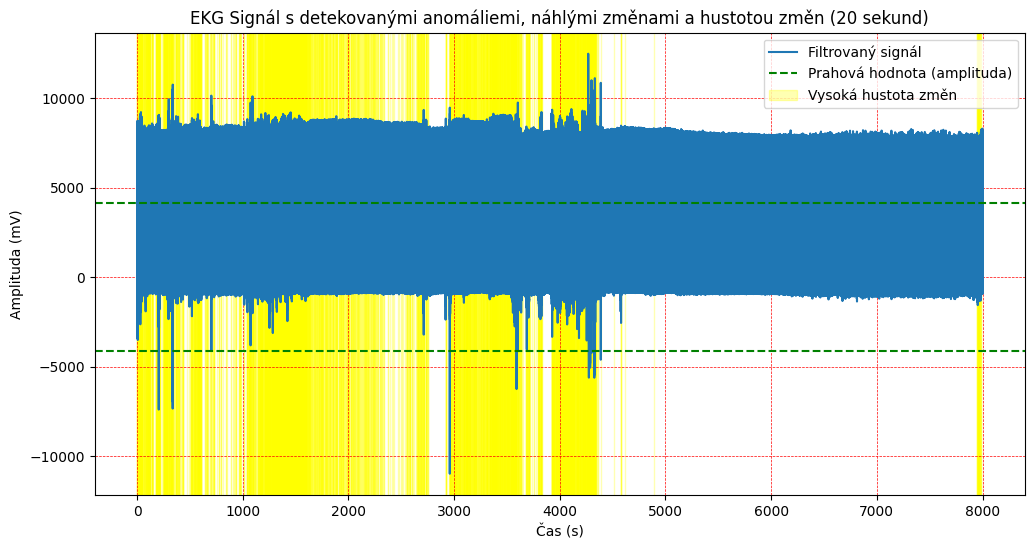

Počet detekovaných anomálií v prvních 8000 sekundách: 189251
Počet detekovaných náhlých změn v prvních 8000 sekundách: 69520


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Funkce pro načtení metadat ze souboru .hea
def load_header(hea_file):
    with open(hea_file, "r") as f:
        lines = f.readlines()
    scale, offset = None, None
    for line in lines:
        if ".dat" in line:
            parts = line.split()
            if len(parts) >= 3:
                scale = float(parts[2].split("(")[0])
                offset = int(parts[2].split("(")[1].split(")")[0])
            break
    if scale is None or offset is None:
        raise ValueError(f"Nelze načíst scale nebo offset ze souboru {hea_file}.")
    return scale, offset

# Funkce pro načtení EKG signálu
def load_ecg_signal(dat_file, scale, offset, dtype=np.int16):
    with open(dat_file, "rb") as f:
        raw_signal = np.fromfile(f, dtype=dtype)
    return (raw_signal + offset) * scale

# Funkce pro aplikaci pásmového filtru
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

# Funkce pro detekci anomálií na základě prahové hodnoty
def detect_anomalies(signal, threshold):
    anomalies = np.where(np.abs(signal) > threshold)[0]
    return anomalies

# Funkce pro výpočet průměrné amplitudy signálu v časových oknech
def compute_average_amplitude(signal, fs, window_size=1):
    samples_per_window = fs * window_size
    avg_amplitude = [np.mean(np.abs(signal[i:i + samples_per_window]))
                     for i in range(0, len(signal), samples_per_window)]
    return np.array(avg_amplitude)

# Funkce pro detekci náhlých změn v signálu (pohybové artefakty)
def detect_sudden_changes(signal, threshold):
    diff_signal = np.diff(signal)  # Rozdíl mezi sousedními vzorky
    sudden_changes = np.where(np.abs(diff_signal) > threshold)[0]
    return sudden_changes

# Funkce pro detekci zahuštění signálu (lokální hustota změn)
def detect_signal_density(signal, fs, window_size=1):
    samples_per_window = fs * window_size
    density = [np.sum(np.abs(np.diff(signal[i:i + samples_per_window])))
               for i in range(0, len(signal), samples_per_window)]
    return np.array(density)

# Parametry
hea_file = "brno-university-of-technology/103001/103001_ECG.hea"
dat_file = "brno-university-of-technology/103001/103001_ECG.dat"
fs = 1000  # Vzorkovací frekvence (Hz)
lowcut = 0.5  # Dolní mez pásmového filtru (Hz)
highcut = 40.0  # Horní mez pásmového filtru (Hz)
duration = 8000  # Délka signálu pro vykreslení (v sekundách)

# Načtení metadat ze souboru .hea
scale, offset = load_header(hea_file)
print(f"Načtené hodnoty: scale={scale}, offset={offset}")

# Načtení EKG signálu ze souboru .dat
ec_signal = load_ecg_signal(dat_file, scale, offset)

# Aplikace pásmového filtru
filtered_signal = bandpass_filter(ec_signal, lowcut, highcut, fs)

# Detekce anomálií
threshold = 3 * np.std(filtered_signal)  # Prahová hodnota (3x standardní odchylka)
anomalies = detect_anomalies(filtered_signal, threshold)

# Detekce náhlých změn
sudden_change_threshold = 5 * np.std(np.diff(filtered_signal))  # Prahová hodnota pro náhlé změny
sudden_changes = detect_sudden_changes(filtered_signal, sudden_change_threshold)

# Detekce zahuštění signálu
density = detect_signal_density(filtered_signal, fs)
time_density = np.arange(len(density))  # 1 hodnota za sekundu

# Výpočet času
time = np.arange(len(filtered_signal)) / fs

# Výběr pouze prvních duration sekund
end_idx = duration * fs
filtered_signal_60s = filtered_signal[:end_idx]
anomalies_60s = anomalies[anomalies < end_idx]
sudden_changes_60s = sudden_changes[sudden_changes < end_idx]
time_60s = time[:end_idx]
density_60s = density[:duration]

# Výpočet průměrné amplitudy
avg_amplitude = compute_average_amplitude(filtered_signal_60s, fs)
time_avg = np.arange(len(avg_amplitude))  # 1 hodnota za sekundu

# Vykreslení signálu s anomáliemi, náhlými změnami a zvýrazněnými zahuštěnými oblastmi
plt.figure(figsize=(12, 6))
plt.plot(time_60s, filtered_signal_60s, label="Filtrovaný signál")
plt.axhline(y=threshold, color="green", linestyle="--", label="Prahová hodnota (amplituda)")
plt.axhline(y=-threshold, color="green", linestyle="--")

# Zvýraznění zahuštěných oblastí pouze pro 20 sekund
high_density_threshold = np.percentile(density_60s, 75)  # Práh pro vysokou hustotu změn
for i, d in enumerate(density_60s):
    if d > high_density_threshold:
        plt.axvspan(i, i + 1, color='yellow', alpha=0.3, label="Vysoká hustota změn" if i == 0 else None)

plt.title("EKG Signál s detekovanými anomáliemi, náhlými změnami a hustotou změn (20 sekund)")
plt.xlabel("Čas (s)")
plt.ylabel("Amplituda (mV)")
plt.grid(color='red', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Statistika anomálií
num_anomalies = len(anomalies_60s)
num_sudden_changes = len(sudden_changes_60s)
print(f"Počet detekovaných anomálií v prvních {duration} sekundách: {num_anomalies}")
print(f"Počet detekovaných náhlých změn v prvních {duration} sekundách: {num_sudden_changes}")



                Statistika    Hodnota
0  Počet shodných anomálií  26.000000
1    Úspěšnost detekce (%)  96.296296


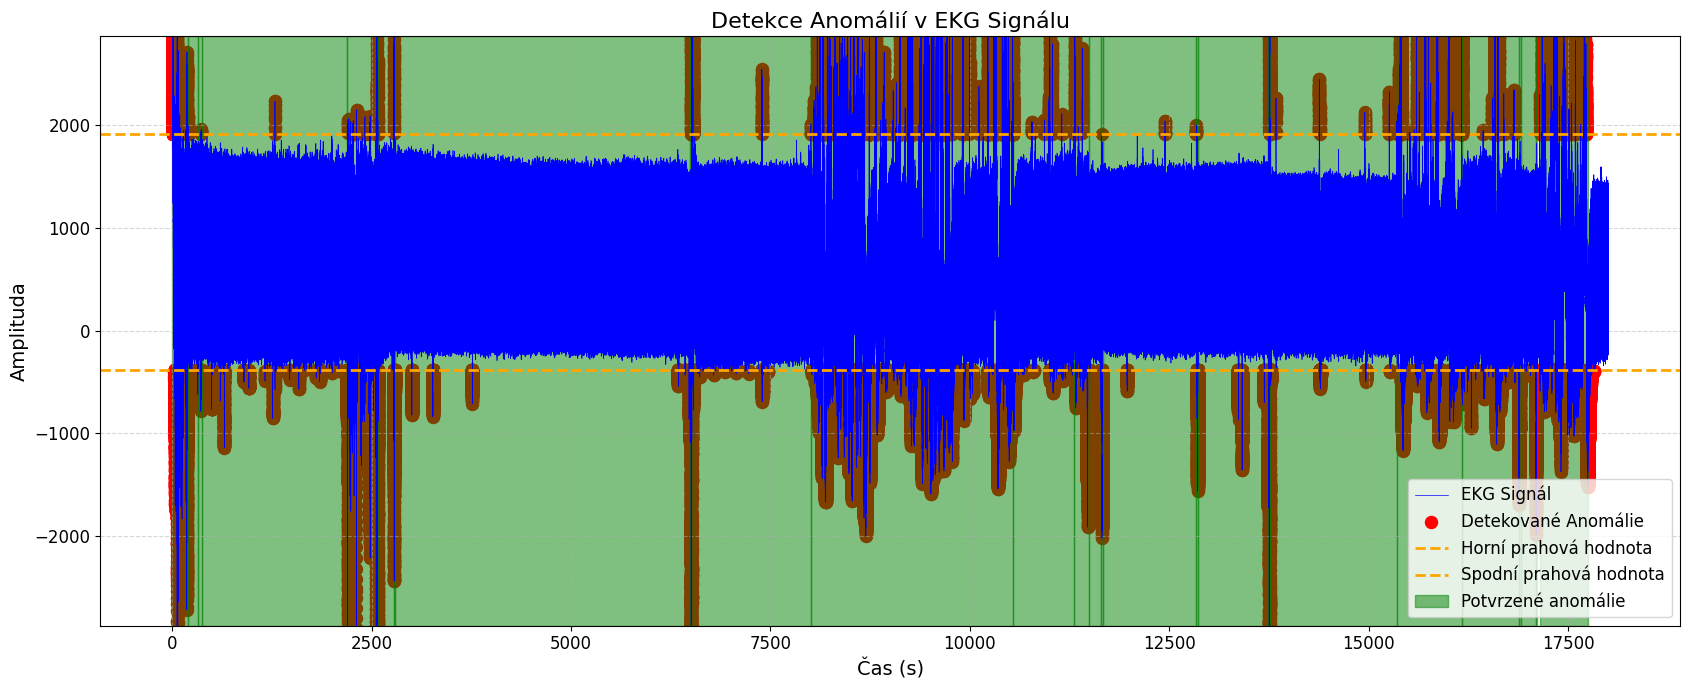

In [3]:
import numpy as np
import wfdb
import pandas as pd
import matplotlib.pyplot as plt

# Funkce pro detekci anomálií na základě amplitudy
def detect_anomalies_amplitude(signal):
    mean_amplitude = np.mean(signal)
    std_amplitude = np.std(signal)
    
    # Dynamické prahování
    threshold_upper = mean_amplitude + 3.7 * std_amplitude
    threshold_lower = mean_amplitude - (3.7 * std_amplitude) / 5  # Spodní hranice je 5× blíže k nule

    anomalies = np.where((signal > threshold_upper) | (signal < threshold_lower))[0]
    
    return anomalies, threshold_upper, threshold_lower

# Funkce pro zpracování signálu a porovnání s anotacemi
def process_signal(record_path, ann_path, sampling_rate=1000, duration=18000):
    try:
        record = wfdb.rdrecord(record_path)
        signal_length = len(record.p_signal)
        max_samples = min(sampling_rate * duration, signal_length)
        signal = record.p_signal[:max_samples, 0]

        # Detekce anomálií na základě amplitudy
        anomalies, threshold_upper, threshold_lower = detect_anomalies_amplitude(signal)

        signal -= np.mean(signal)

        # Načtení anotací a filtrování záznamů s nulovým ohodnocením
        annotations = pd.read_csv(ann_path, header=None)
        annotations = annotations[annotations.iloc[:, 2] != 0]  # Ignorovat řádky, kde je třetí sloupec 0
        annotation_start = annotations.iloc[:, 0].values
        annotation_end = annotations.iloc[:, 1].values

        valid_annotations = (annotation_start < max_samples) & (annotation_end < max_samples)
        annotation_start = annotation_start[valid_annotations]
        annotation_end = annotation_end[valid_annotations]

        matching_annotations = sum(1 for start, end in zip(annotation_start, annotation_end) if any(start <= anomaly < end for anomaly in anomalies))
        total_annotations = len(annotation_start)

        num_anomalies = len(anomalies)
        success_rate = matching_annotations / total_annotations if total_annotations > 0 else 0

        # Vytvoření tabulky se statistickými ukazateli
        stats = {
            'Statistika': ['Počet shodných anomálií', 'Úspěšnost detekce (%)'],
            'Hodnota': [matching_annotations, success_rate * 100]
        }
        stats_df = pd.DataFrame(stats)
        print(stats_df)

        time = np.arange(len(signal)) / sampling_rate
        plt.figure(figsize=(17, 7))
        plt.plot(time, signal, label='EKG Signál', color='blue', linewidth=0.5)

        # Zvýraznění detekovaných anomálií
        plt.scatter(time[anomalies], signal[anomalies], color='red', label='Detekované Anomálie', zorder=1, s=75)

        # Vyznačení prahových hodnot
        plt.axhline(y=threshold_upper, color='orange', linestyle='--', linewidth=2, label='Horní prahová hodnota')
        plt.axhline(y=threshold_lower, color='orange', linestyle='--', linewidth=2, label='Spodní prahová hodnota')

        # Zobrazení anotací (zelený obdélník pouze tam, kde je detekovaná anomálie)
        for start, end in zip(annotation_start, annotation_end):
            # Kontrola, zda existuje nějaká detekovaná anomálie v tomto úseku
            matching_anomalies = [anomaly for anomaly in anomalies if start <= anomaly < end]
            if matching_anomalies:
                plt.axvspan(start / sampling_rate, end / sampling_rate, color='green', alpha=0.5, label='Potvrzené anomálie' if start == annotation_start[0] else "")

        plt.ylim(-1.5 * threshold_upper, 1.5 * threshold_upper)

        plt.grid(True, linestyle='--', alpha=0.5)

        plt.title('Detekce Anomálií v EKG Signálu', fontsize=16)
        plt.xlabel('Čas (s)', fontsize=14)
        plt.ylabel('Amplituda', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(fontsize=12, loc='lower right')
        plt.tight_layout()
        plt.show()

        return num_anomalies, matching_annotations, success_rate

    except Exception as e:
        print(f"Chyba při zpracování {record_path}: {e}")
        return 0, 0, 0

record_path = 'brno-university-of-technology/100001/100001_ECG'  # Cesta k souboru EKG signálu
ann_path = 'brno-university-of-technology/100001/100001_ANN.csv'  # Cesta k souboru anotací

num_anomalies, num_matching, success_rate = process_signal(record_path, ann_path)


In [31]:
import pandas as pd

# Načtení anotací
ann_path = 'brno-university-of-technology/100001/100001_ANN.csv'
annotations = pd.read_csv(ann_path, header=None)

# Najít poslední platné číslo ve sloupci 9 (celkový počet vzorků)
if 9 in annotations.columns and 11 in annotations.columns:
    total_samples = int(annotations[10].dropna().iloc[-1])  # Poslední číslo bez NaN
    print(f"Celkový počet vzorků: {total_samples}")

    # Počet úseků
    num_chunks = 100
    chunk_size = total_samples // num_chunks

    # Generování nových úseků
    new_annotations = []
    for i in range(num_chunks):
        start = i * chunk_size
        end = (i + 1) * chunk_size - 1

        # Filtrovat data pro aktuální chunk
        chunk_data = annotations[(annotations[9] >= start) & (annotations[9] <= end)]
        
        # Najít maximální hodnotu ve sloupci 11 pro tento chunk
        max_value = chunk_data[11].max() if not chunk_data.empty else 0

        # Přidat úsek do nového seznamu
        new_annotations.append([start, end, max_value])

    # Úprava posledního úseku na přesný konec
    new_annotations[-1][1] = total_samples

    # Vytvoření DataFrame
    new_annotations_df = pd.DataFrame(new_annotations, columns=["start", "end", "value"])

    # Uložení do CSV
    new_annotations_df.to_csv("new_annotations.csv", index=False)

    print(new_annotations_df)
else:
    print("Sloupce 9 a/nebo 11 neexistují v souboru.")




Celkový počet vzorků: 87087000
       start       end  value
0          0    870869    2.0
1     870870   1741739    2.0
2    1741740   2612609    2.0
3    2612610   3483479    2.0
4    3483480   4354349    0.0
..       ...       ...    ...
95  82732650  83603519    2.0
96  83603520  84474389    2.0
97  84474390  85345259    2.0
98  85345260  86216129    2.0
99  86216130  87087000    2.0

[100 rows x 3 columns]


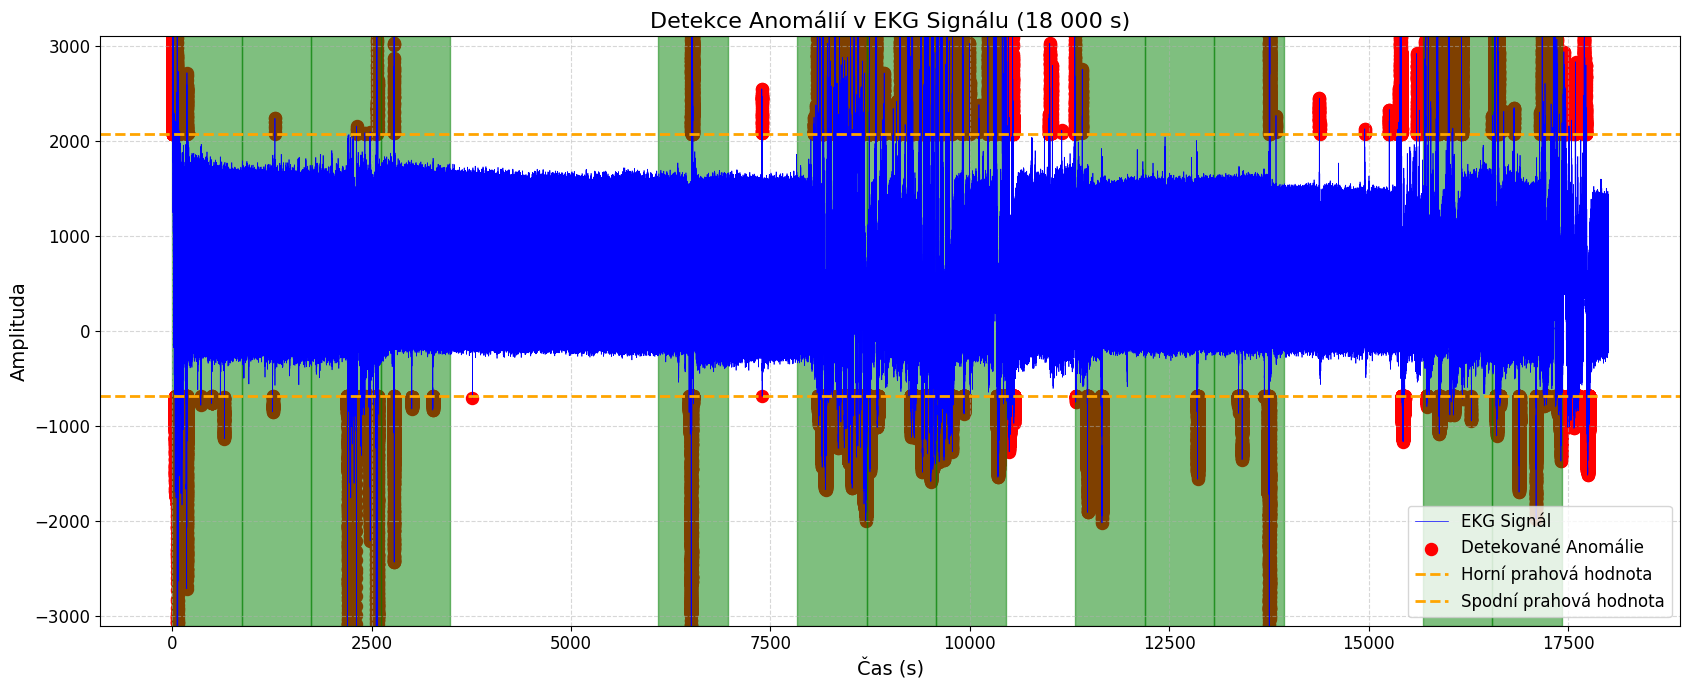

In [4]:
import numpy as np
import wfdb
import pandas as pd
import matplotlib.pyplot as plt

# Funkce pro detekci anomálií na základě amplitudy
def detect_anomalies_amplitude(signal):
    mean_amplitude = np.mean(signal)
    std_amplitude = np.std(signal)
    
    # Dynamické prahování
    threshold_upper = mean_amplitude + 4 * std_amplitude
    threshold_lower = mean_amplitude - (4 * std_amplitude) / 3  # Spodní hranice je 3× blíže k nule

    anomalies = np.where((signal > threshold_upper) | (signal < threshold_lower))[0]
    
    return anomalies, threshold_upper, threshold_lower

# Funkce pro zpracování signálu a porovnání s anotacemi
def process_signal(record_path, new_ann_path, sampling_rate=1000, duration=18000):
    try:
        record = wfdb.rdrecord(record_path)
        signal_length = len(record.p_signal)
        max_samples = min(sampling_rate * duration, signal_length)
        signal = record.p_signal[:max_samples, 0]

        # Detekce anomálií na základě amplitudy
        anomalies, threshold_upper, threshold_lower = detect_anomalies_amplitude(signal)

        signal -= np.mean(signal)

        # Načtení nových anotací (s hodnotami v posledním sloupci)
        annotations = pd.read_csv(new_ann_path)

        # Filtrování anotací pouze na rozsah 18 000 sekund
        annotations = annotations[(annotations['start'] / sampling_rate <= duration) & 
                                   (annotations['end'] / sampling_rate <= duration)]

        time = np.arange(len(signal)) / sampling_rate
        plt.figure(figsize=(17, 7))
        plt.plot(time, signal, label='EKG Signál', color='blue', linewidth=0.5)

        # Zvýraznění detekovaných anomálií
        plt.scatter(time[anomalies], signal[anomalies], color='red', label='Detekované Anomálie', zorder=1, s=75)

        # Vyznačení prahových hodnot
        plt.axhline(y=threshold_upper, color='orange', linestyle='--', linewidth=2, label='Horní prahová hodnota')
        plt.axhline(y=threshold_lower, color='orange', linestyle='--', linewidth=2, label='Spodní prahová hodnota')

        # Zobrazení anotací (zelený obdélník pouze pokud hodnota není 0 nebo 1)
        for _, row in annotations.iterrows():
            start = row['start']
            end = row['end']
            value = row['value']
            if value not in [0, 1]:  # Vynechat, pokud hodnota je 0 nebo 1
                plt.axvspan(start / sampling_rate, end / sampling_rate, color='green', alpha=0.5)

        plt.ylim(-1.5 * threshold_upper, 1.5 * threshold_upper)

        plt.grid(True, linestyle='--', alpha=0.5)

        plt.title('Detekce Anomálií v EKG Signálu (18 000 s)', fontsize=16)
        plt.xlabel('Čas (s)', fontsize=14)
        plt.ylabel('Amplituda', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(fontsize=12, loc='lower right')
        plt.tight_layout()
        plt.show()

        return len(anomalies), 0, 0
    except Exception as e:
        print(f"Chyba při zpracování {record_path}: {e}")
        return 0, 0, 0

# Cesty k datovým souborům
record_path = 'brno-university-of-technology/100001/100001_ECG'  # Cesta k souboru EKG signálu
new_ann_path = 'new_annotations.csv'  # Cesta k novému souboru anotací

# Volání funkce s omezením na 18 000 sekund
num_anomalies, num_matching, success_rate = process_signal(record_path, new_ann_path, duration=18000)

